In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

: 

In [49]:
# Read the data from csv
X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')

In [50]:
# drop the id column, useless for training
X.drop(labels='id', axis=1, inplace=True)
y.drop(labels='id', axis=1, inplace=True)

In [51]:
# Stage 1 :: Data Imputation --> KNNImputer
from sklearn.impute import KNNImputer

X_index, X_columns = X.index, X.columns
knn_impute = KNNImputer(n_neighbors=10, weights='distance')
X = knn_impute.fit_transform(X)

In [52]:
X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [53]:
print(X.shape)
X = X.drop_duplicates()
print(X.shape)

(1212, 832)
(1212, 832)


In [54]:
# Stage 2: Feature selection --> Remove columns with zero variance
mask_ = X.var(axis=0) != 0
X = X.loc[:, mask_]
print(X.shape)

(1212, 828)


In [55]:
print(X.isnull().sum().sum()) # check imputer

0


In [56]:
# Load X_test only for visualisation purposes
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test.drop(labels='id', axis=1, inplace=True)
X_test = knn_impute.transform(X_test)

X_test = X_test[:, mask_]

In [57]:
from sklearn.preprocessing import QuantileTransformer

rbc = QuantileTransformer(n_quantiles=X.shape[0], output_distribution='normal')
X_scaled = rbc.fit_transform(X)
X_test_scaled = rbc.transform(X_test)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


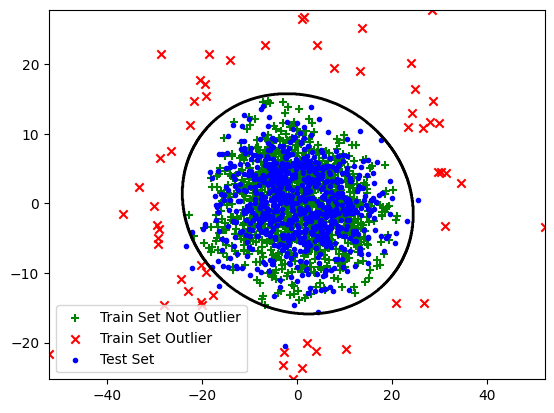

In [58]:
# Stage 3 :: Outlier Detection
# Some motivation for this approach --> since we're trying to maximize 
# r2 score on the test set and we don't have the gt label for the test set
# we only have to consider the points int the training set that are in accordance with 
# the points in the test set, i.e the outliers are the points which are far of the elliptic
# envelope decision boundary

from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

fig, ax = plt.subplots()

pca = PCA(n_components=2)
X_project = pca.fit_transform(X_scaled)
X_test_project = pca.transform(X_test_scaled)

ax.set_xlim(left=X_project[:, 0].min(), right=X_project[:, 0].max())
ax.set_ylim(bottom=X_project[:, 1].min(), top=X_project[:, 1].max())

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(X_project[:, 0].min(), \
X_project[:, 0].max(), 1000), np.linspace(X_project[:, 1].min(), \
    X_project[:, 1].max(), 1000))

elliptic = EllipticEnvelope(contamination=0.047)
outliers = elliptic.fit_predict(X_project)
mask_outliers_out = outliers != -1
X_project_not_outliers = X_project[mask_outliers_out, :]
X_project_outliers = X_project[~mask_outliers_out, :]

ax.scatter(X_project_not_outliers[:, 0], X_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(X_project_outliers[:, 0], X_project_outliers[:, 1], marker='x', color='red')
ax.scatter(X_test_project[:, 0], X_test_project[:, 1], marker='.', color='blue')
Z = elliptic.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Train Set Not Outlier', 'Train Set Outlier', 'Test Set'])

plt.show()

In [59]:
print(mask_outliers_out.sum())

1155


In [61]:
print(X.shape[0])

1212


In [62]:
# Outlier removal
X = X.loc[mask_outliers_out, :]
y = y.loc[mask_outliers_out, :]

In [63]:
print(X.isnull().sum().sum())

0


In [64]:
from sklearn.preprocessing import QuantileTransformer

rbc = QuantileTransformer(n_quantiles=X.shape[0], output_distribution='normal')
X_index, X_columns = X.index, X.columns
X = rbc.fit_transform(X)
X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [65]:
# Feature Selection :: Here based on mutual information score
# from sklearn.feature_selection import mutual_info_regression
# mutual_info_w_target = mutual_info_regression(X, y.squeeze())
# X = X.loc[:, mutual_info_w_target > 0.1]

# Feature Selection :: Here based on highest correlation
# compute the feature_corr
print(f'Shape before feature selection (X_train//X_test) is {(X.shape)}')
feature_corr = X.corrwith(y.squeeze()).abs() > 0.2
X = X.loc[:, feature_corr]
print(f'Shape after feature selection (X_train//X_test) is {(X.shape)}')

# Feature Selection :: I will do this based on the feature importances of our best model, that is LGBM_Regressor
# n_samples = X.shape[0]

# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import Pipeline 
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

# kernel_ridge_regressor = Pipeline([ 
#     ('scaler', QuantileTransformer(output_distribution='normal')),
#     ('kernel_ridge', KernelRidge())
# ])

# param_grid = { 
#     'scaler__n_quantiles': [n_samples // 4, n_samples // 2, 3 * n_samples // 4, n_samples],
#     'kernel_ridge__alpha' : [1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
#     'kernel_ridge__kernel': ['poly', 'rbf', 'linear', 'laplacian'],
#     'kernel_ridge__degree': [2, 3, 4, 5, 6], 
#     'kernel_ridge__gamma': [0.01, 0.1, 1, 10], 
#     'kernel_ridge__coef0': [0, 1, 10, 100]
# }

# kernelridge_grid = RandomizedSearchCV(kernel_ridge_regressor, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
# kernelridge_grid.fit(X, y.squeeze())

# kernel_ridge_regressor_best_estimator = kernelridge_grid.best_estimator_

# r2_score_train = r2_score(y, kernel_ridge_regressor_best_estimator.predict(X))
# print('----')
# print(f'Train r2 score: {r2_score_train}')
# print('----')

Shape before feature selection (X_train//X_test) is (1155, 828)
Shape after feature selection (X_train//X_test) is (1155, 150)


In [66]:
X.shape

(1155, 150)

In [67]:
# Empirically the more features, the higher generalisation, so we would only need to 
# remove the highly correlated features
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr
mask_multicorr = filter_multicolinearity(X, 0.85)
X = X.loc[:, mask_multicorr]

In [68]:
mask_multicorr.shape

(150,)

In [69]:
print(X.shape)

(1155, 131)


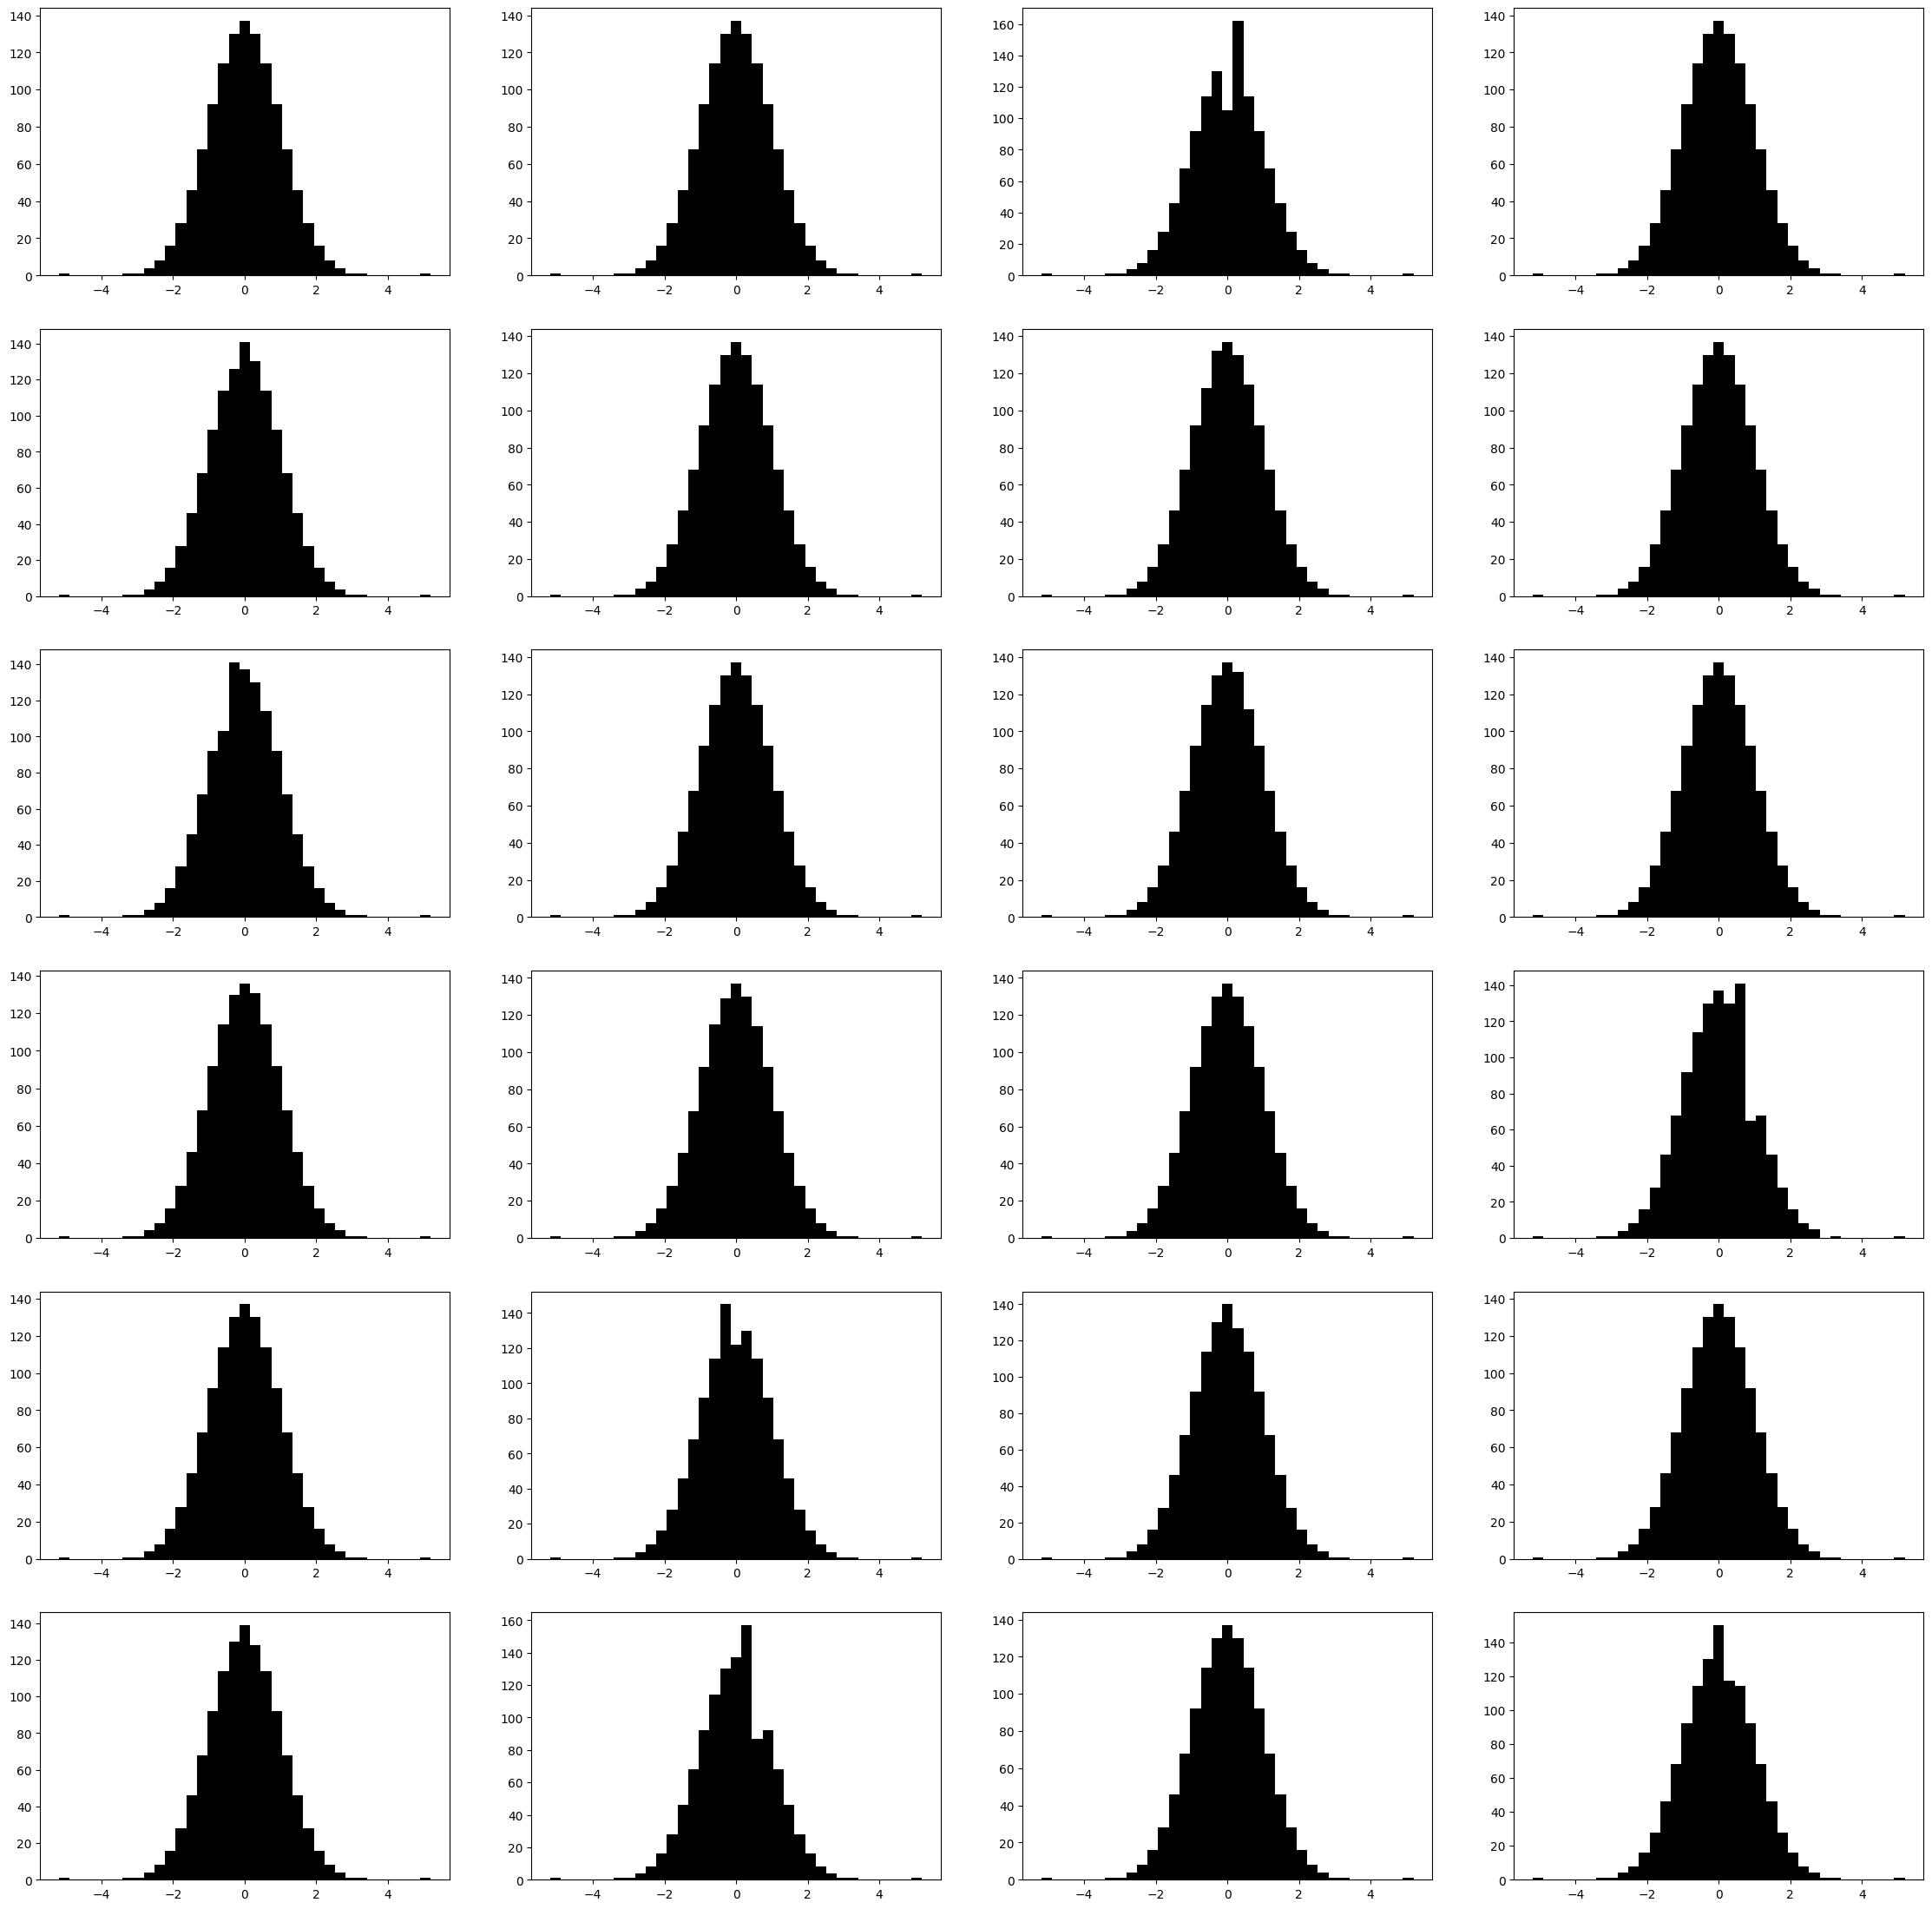

In [70]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(28, 28))

for i in range(24):
    ax[i // 4, i % 4].hist(X.iloc[:, i], bins=35, color='black')
plt.show()

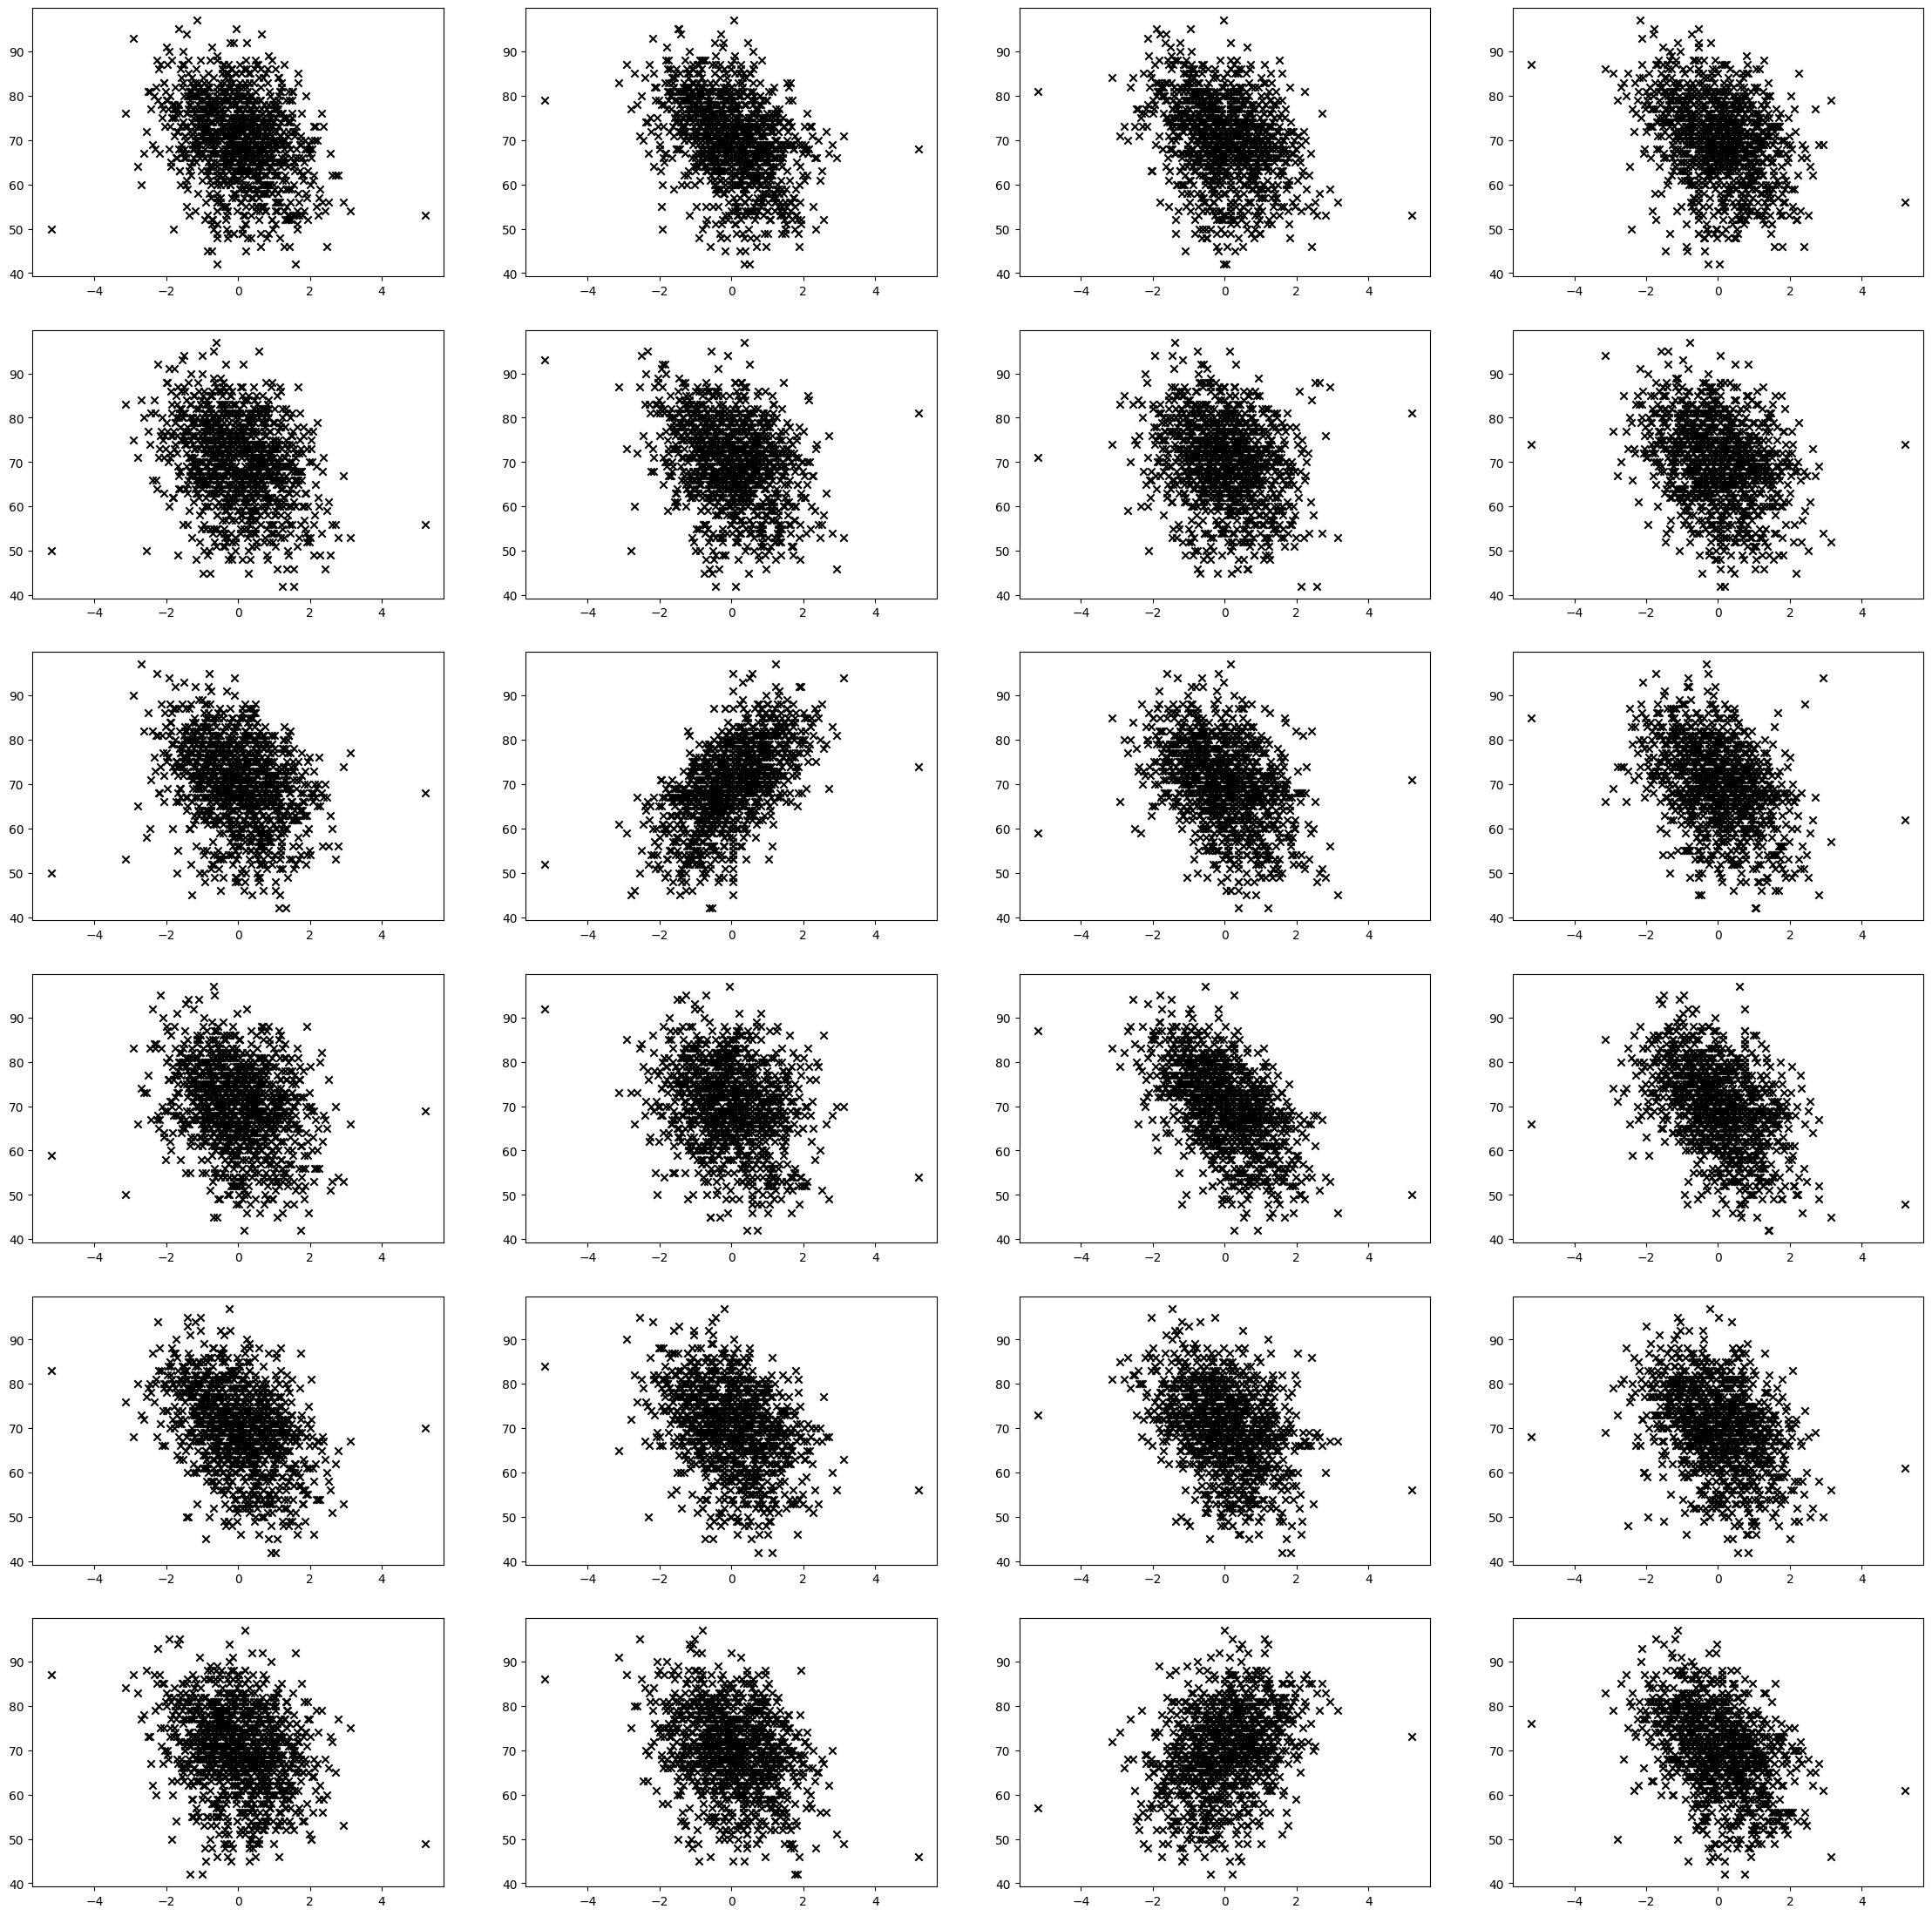

In [71]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(28, 28))

for i in range(24):
    ax[i // 4, i % 4].scatter(X.iloc[:, i], y, marker='x',color='black')
plt.show()

In [ ]:
# Very nice, so it deskewed our distribution, making it more gaussian like which is great for linear regression

In [25]:
# We still see one or two outliers so for me contamination is still around 0.1

from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=200, contamination=0.01)
outliers_to_the_trend = iso_forest.fit_predict(np.concatenate([X, y], axis=1))
mask_trend = outliers_to_the_trend != -1


IndexError: index 8 is out of bounds for axis 0 with size 8

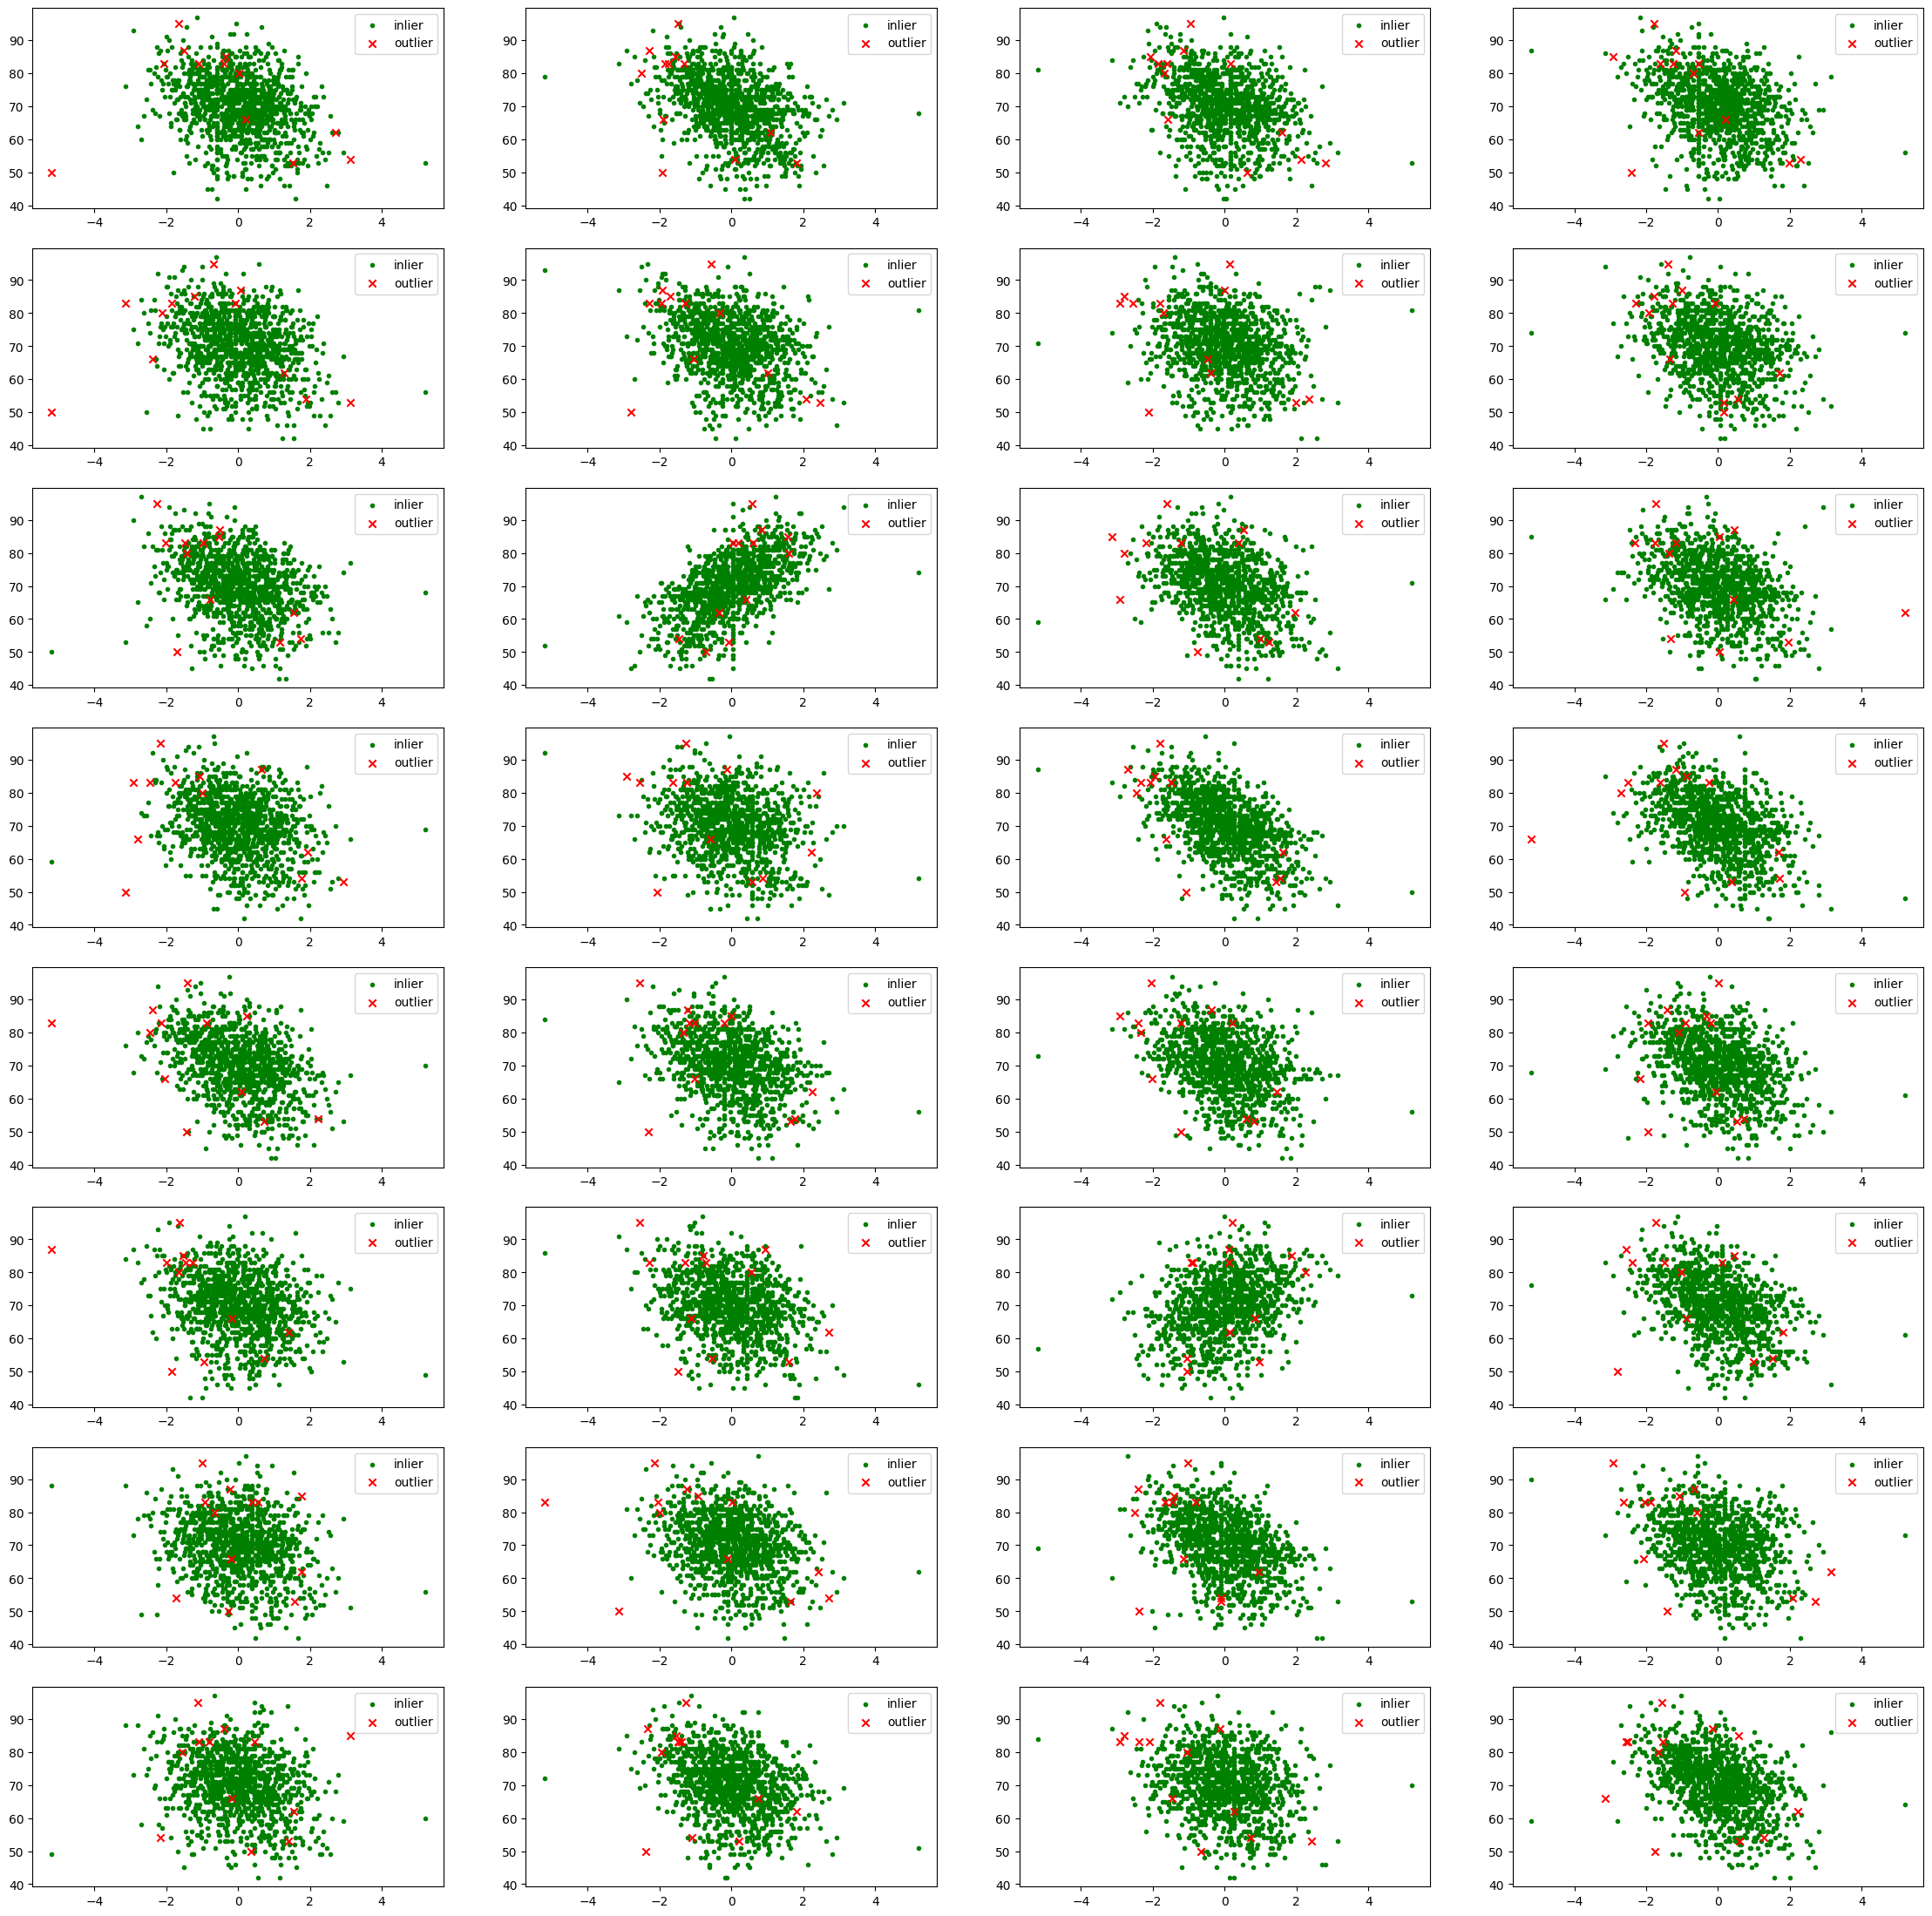

In [26]:
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(28, 28))

for i in range(X.shape[1]):
    ax[i // 4, i % 4].scatter(X.loc[mask_trend].iloc[:, i], y.loc[mask_trend], marker='.',color='green')
    ax[i // 4, i % 4].scatter(X.loc[~mask_trend].iloc[:, i], y.loc[~mask_trend], marker='x', color='red')
    ax[i // 4, i % 4].legend(['inlier', 'outlier'])
plt.show()

In [237]:
# Either one has to fit an elliptic envelope to each of the axes, or one has to delete valuable sample
# i'll keep those outliers in red for now....

From the observations above we notice that some of the data is heavily skewed
Which implies that we might need to perform a quantile transform and not just a simple robust median centering/IQR scalign.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## Model Selection -- Without Scaling this time as it has already been done

# SVR 

In [28]:

# first test with the Robust Scaler

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

svr = Pipeline([ 
    ('svr', SVR())
])

param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__gamma' : ['scale', 'auto', 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1], 
    'svr__C': [1e-2, 1e-1, 1, 1e1], 
    'svr__epsilon': [1e-3, 1e-2, 1e-1, 5e-1, 1]
}

svr_grid = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
svr_grid.fit(X_train, y_train.squeeze())

svr_best_estimator = svr_grid.best_estimator_

r2_score_train = r2_score(y_train, svr_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9150885490155782
Test r2 score: 0.635948546903917
----


In [29]:
svr_grid.best_params_

{'svr__C': 10.0,
 'svr__epsilon': 0.1,
 'svr__gamma': 'auto',
 'svr__kernel': 'rbf'}

In [30]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

extra_tree_reg = Pipeline([ 
    ('tree_reg', ExtraTreesRegressor())
])

param_grid = {
    'tree_reg__n_estimators' : [100, 200, 300, 400, 500], # Values chosen empirically, the more the trees the more 
    # the stability of the model, works like in bootstrap, intuition being the SLLN and CLT 
    'tree_reg__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'tree_reg__max_depth': [5, 10, 15, 20, 30, 50], # Prevents overfitting, the deeper the tree the more noise it captures
    'tree_reg__max_features': ['sqrt', 'log2', 0.5, None], # reducing this increases randomness in the model, because it limits the nb of features used within each split 
    'tree_reg__min_samples_split': [2, 5, 10, 15], # higher values prevent the model to overfit to the noise
    'tree_reg__min_samples_leaf': [1, 2, 4, 10, 15], # higher values smooth the model, as leaves with very few samples represent outliers
    'tree_reg__min_impurity_decrease': [1e-3, 1e-2, 1e-1, 0] # i'm not an expert, just added mb this improves something
}

xtra_tree_grid = RandomizedSearchCV(extra_tree_reg, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
xtra_tree_grid.fit(X_train, y_train.squeeze())

extra_tree_reg_best_estimator = xtra_tree_grid.best_estimator_

r2_score_train = r2_score(y_train, extra_tree_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, extra_tree_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9764447356413574
Test r2 score: 0.5959432066983341
----


In [31]:
xtra_tree_grid.best_params_

{'tree_reg__n_estimators': 100,
 'tree_reg__min_samples_split': 10,
 'tree_reg__min_samples_leaf': 1,
 'tree_reg__min_impurity_decrease': 0.001,
 'tree_reg__max_features': 0.5,
 'tree_reg__max_depth': 20,
 'tree_reg__criterion': 'absolute_error'}

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer

random_forest_regressor = Pipeline([ 
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' :  [100, 300, 500, 750, 1000], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [None, 10, 20, 50, 100, 150], 
    'random_forest_regressor__min_samples_split': [2, 5, 10, 15], 
    'random_forest_regressor__min_samples_leaf': [1, 2, 4, 6, 10], 
    'random_forest_regressor__max_features': [None, 'sqrt', 'log2', 0.5], 
    'random_forest_regressor__max_leaf_nodes': [None, 10, 20, 100, 200, 250], 
    'random_forest_regressor__bootstrap': [True, False], 
    'random_forest_regressor__min_impurity_decrease': [0.0, 0.01, 0.1]
}

random_forest_regressor_grid = RandomizedSearchCV(random_forest_regressor, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
random_forest_regressor_grid.fit(X_train, y_train.squeeze())

random_forest_regressor_best_estimator = random_forest_regressor_grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9606356513467565
Test r2 score: 0.5978163983451728
----


In [33]:
random_forest_regressor_grid.best_params_

{'random_forest_regressor__n_estimators': 100,
 'random_forest_regressor__min_samples_split': 5,
 'random_forest_regressor__min_samples_leaf': 2,
 'random_forest_regressor__min_impurity_decrease': 0.1,
 'random_forest_regressor__max_leaf_nodes': 100,
 'random_forest_regressor__max_features': 0.5,
 'random_forest_regressor__max_depth': 20,
 'random_forest_regressor__criterion': 'squared_error',
 'random_forest_regressor__bootstrap': False}

In [34]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures

kernel_ridge_regressor = Pipeline([ 
    ('kernel_ridge', KernelRidge())
])

param_grid = { 
    'kernel_ridge__alpha' : [1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
    'kernel_ridge__kernel': ['poly', 'rbf', 'linear', 'laplacian'],
    'kernel_ridge__degree': [2, 3, 4, 5, 6], 
    'kernel_ridge__gamma': [0.01, 0.1, 1, 10], 
    'kernel_ridge__coef0': [0, 1, 10, 100]
}

kernelridge_grid = RandomizedSearchCV(kernel_ridge_regressor, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
kernelridge_grid.fit(X_train, y_train.squeeze())

kernel_ridge_regressor_best_estimator = kernelridge_grid.best_estimator_

r2_score_train = r2_score(y_train, kernel_ridge_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, kernel_ridge_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 1.0
Test r2 score: 0.27486673887403634
----


In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer

knn_reg = Pipeline([ 
    ('knn_reg', KNeighborsRegressor())
])

param_grid = { 
    'knn_reg__n_neighbors' : [5, 10, 15, 20, 25, 30, 35],
    'knn_reg__weights' : ['uniform', 'distance'], 
    'knn_reg__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn_reg__leaf_size': [1, 10, 20, 30, 40, 50, 80, 100],
    'knn_reg__metric': ['euclidean', 'l1', 'l2', 'manhattan', 'minkowski'], 
    'knn_reg__p': [3, 4, 5]
}

knn_reg_grid = RandomizedSearchCV(knn_reg, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
knn_reg_grid.fit(X_train, y_train.squeeze())

knn_reg_best_estimator = knn_reg_grid.best_estimator_

r2_score_train = r2_score(y_train, knn_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, knn_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


----
Train r2 score: 1.0
Test r2 score: 0.4926398177628274
----


In [36]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


xgb_pipeline = Pipeline([
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))
])

param_grid = {
    'xgb__n_estimators': [50, 100, 200, 250],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__gamma': [0, 0.1, 0.3],
}

xgb_pipeline_grid = RandomizedSearchCV(estimator=xgb_pipeline, 
                                   param_distributions=param_grid, 
                                   n_iter=20,  
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=1, 
                                   n_jobs=-1, 
                                   random_state=42)


xgb_pipeline_grid.fit(X_train, y_train)
best_xgb_reg = xgb_pipeline_grid.best_estimator_

r2_score_train = r2_score(y_train, best_xgb_reg.predict(X_train))
r2_score_test = r2_score(y_test, best_xgb_reg.predict(X_test))

print("Best parameters found: ", xgb_pipeline_grid.best_params_)
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'xgb__subsample': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.8}
----
Train r2 score: 0.9498093724250793
Test r2 score: 0.6352874040603638
----


In [37]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


lgbm_pipeline = Pipeline([
    ('lightgbm', LGBMRegressor())
])

param_grid = {
    'lightgbm__num_leaves': [20, 30, 40, 50, 60, 70, 100, 150],
    'lightgbm__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1],
    'lightgbm__n_estimators': [100, 200, 300, 500, 1000],
    'lightgbm__max_depth': [3, 5, 7, 10, 15, 30, 50],
    'lightgbm__min_child_samples': [10, 20, 30, 40, 50, 100, 150],
    'lightgbm__subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0],
    'lightgbm__colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0], 
    'lightgbm__reg_alpha': [1e-3, 1e-2, 1, 1e1, 1e2], 
    'lightgbm__reg_lambda': [0, 1e-1, 1e-2, 1e1]
}


lgbm_pipeline_grid = RandomizedSearchCV(estimator=lgbm_pipeline, 
                                   param_distributions=param_grid, 
                                   n_iter=20,  
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1, 
                                   random_state=42)


lgbm_pipeline_grid.fit(X_train, y_train)
best_lgbm_reg = lgbm_pipeline_grid.best_estimator_


r2_score_train = r2_score(y_train, best_lgbm_reg.predict(X_train))
r2_score_test = r2_score(y_test, best_lgbm_reg.predict(X_test))

print("Best parameters found: ", lgbm_pipeline_grid.best_params_)
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33397
[LightGBM] [Info] Total Bins 33396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33397[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 785, number of used features: 131

[LightGBM] [Info] Total Bins 33395
[LightGBM] [Info] Start training from score 70.262420
[LightGBM] [Info] Number of data points in the train set: 784, num

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import GradientBoostingRegressor

gradient_booster_reg = Pipeline([ 
    ('gradient_booster_reg', GradientBoostingRegressor())
])

param_grid = { 
    'gradient_booster_reg__n_estimators': [100, 200, 300, 500, 1000],
    'gradient_booster_reg__learning_rate': [1e-2, 1e-1, 5e-1, 1],
    'gradient_booster_reg__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
    'gradient_booster_reg__n_estimators': [100, 150, 200, 250, 300], 
    'gradient_booster_reg__criterion': ['friedman_mse', 'squared_error'], 
    'gradient_booster_reg__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
    'gradient_booster_reg__min_samples_split': [2, 5, 10, 15]
}

gbm_grid = RandomizedSearchCV(gradient_booster_reg, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
gbm_grid.fit(X_train, y_train.squeeze())

gradient_booster_reg_best_estimator = gbm_grid.best_estimator_

r2_score_train = r2_score(y_train, gradient_booster_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, gradient_booster_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


----
Train r2 score: 0.9999409036778795
Test r2 score: 0.6382669861283576
----


In [39]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures


huber_pipeline = Pipeline([
    ('huber', HuberRegressor())
])

param_grid = { 
    'huber__epsilon': [1, 1.5, 2, 2.5, 3, 3.5, 4], 
    'huber__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
}


huber_pipeline_grid = GridSearchCV(estimator=huber_pipeline, 
                                   param_grid=param_grid,   
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)


huber_pipeline_grid.fit(X_train, y_train.squeeze())
best_huber_reg = huber_pipeline_grid.best_estimator_


r2_score_train = r2_score(y_train, best_huber_reg.predict(X_train))
r2_score_test = r2_score(y_test, best_huber_reg.predict(X_test))

print("Best parameters found: ", huber_pipeline_grid.best_params_)
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_huber.py:342: Converg

Best parameters found:  {'huber__alpha': 100.0, 'huber__epsilon': 2}
----
Train r2 score: 0.6315194248459499
Test r2 score: 0.5890600451911984
----


In [40]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures


elasticnet_pipeline = Pipeline([
    ('elasticnet', ElasticNet())
])

param_grid = { 
    'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
    'elasticnet__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], 
    'elasticnet__selection': ['cyclic', 'random']
}


elasticnet_pipeline_grid = GridSearchCV(estimator=elasticnet_pipeline, 
                                   param_grid=param_grid,   
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)


elasticnet_pipeline_grid.fit(X_train, y_train.squeeze())
best_elasticnet_reg = elasticnet_pipeline_grid.best_estimator_


r2_score_train = r2_score(y_train, best_elasticnet_reg.predict(X_train))
r2_score_test = r2_score(y_test, best_elasticnet_reg.predict(X_test))

print("Best parameters found: ", elasticnet_pipeline_grid.best_params_)
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.528e+03, tolerance: 7.042e+00
  model = cd_fast.enet_coordinate_descent(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.625e+03, tolerance: 6.738e+00
  model = cd_fast.enet_coordinate_descent(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the

Best parameters found:  {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9, 'elasticnet__selection': 'cyclic'}
----
Train r2 score: 0.6595210508811498
Test r2 score: 0.6115778015105535
----


In [41]:
from sklearn.ensemble import VotingRegressor

v_reg = VotingRegressor(
    estimators=[
        ('svr_q', svr_best_estimator), 
        ('xgb', best_xgb_reg), 
        ('lgbm', best_lgbm_reg), 
        ('gbm', gradient_booster_reg_best_estimator)
    ], 
    weights=[0.2, 0.2, 0.4, 0.2]
)

v_reg.fit(X_train, y_train.squeeze())
r2_score(y_test, v_reg.predict(X_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 981, number of used features: 131
[LightGBM] [Info] Start training from score 70.058104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

0.671672659893172

In [47]:
X_train.shape

(981, 131)

In [42]:
v_reg.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 1155, number of used features: 131
[LightGBM] [Info] Start training from score 69.955844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

VotingRegressor(estimators=[('svr_q',
                             Pipeline(steps=[('svr',
                                              SVR(C=10.0, gamma='auto'))])),
                            ('xgb',
                             Pipeline(steps=[('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=0.8,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=0....
                             Pipeline(steps=[('lightgbm',
                                              LGBMRegressor(colsample_bytree=0.8,
                                                            learning_rate=0.01,
                                                            max_depth=50,
                                                            min_child_samples=40,
                                                            n_estimators=1000,
                                                            num_leaves=150,
                                                            reg_alpha=0.001,
                                                            reg_lambda=0.01,
                                                            subsample=0.75))])),
                            ('gbm',
                             Pipeline(steps=[('gradient_booster_reg',
                                              GradientBoostingRegressor(criterion='squared_error',
                                                                        max_depth=5,
                                                                        n_estimators=300))]))],
                weights=[0.2, 0.2, 0.4, 0.2])

In [44]:
feature_corr.shape

(828,)

In [45]:
mask_multicorr.shape

(136,)

In [72]:
# Load the test data
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)



# data imputation and feature selection
X_test = knn_impute.transform(X_test)

# delete zero variance cols
X_test = X_test[:, mask_]

# quantile transformer
X_test = rbc.transform(X_test)

# filter out cols
X_test = X_test[:, feature_corr]
X_test = X_test[:, mask_multicorr]

# Make predictions
predictions = v_reg.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': X_test_id, 'y': predictions})
submission.to_csv('submission_bis.csv', index=False)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [178]:
from sklearn.ensemble import StackingRegressor

s_reg = StackingRegressor(
    estimators=[
        ('svr_q', svr_quant_best_estimator), 
        ('xtra', extra_tree_reg_best_estimator), 
        ('random_forest', random_forest_regressor), 
        ('ridge', kernel_ridge_regressor_best_estimator),
        ('knn_reg', knn_reg_best_estimator), 
        ('xgb', best_xgb_reg), 
        ('gbm', gradient_booster_reg_best_estimator)
    ],
    final_estimator=best_lgbm_reg, 
    passthrough=True
)

s_reg.fit(X_train, y_train)

r2_score(y_test, s_reg.predict(X_test))

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (909). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (909) is greater than the total number of samples (727). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (909) is greater than the total num

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 909, number of used features: 38
[LightGBM] [Info] Start training from score 69.688669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

0.5954309690174102

In [184]:
from sklearn.ensemble import VotingRegressor

v_reg = VotingRegressor(
    estimators=[
        ('svr_q', svr_best_estimator), 
        ('xtra', extra_tree_reg_best_estimator), 
        ('ridge', kernel_ridge_regressor_best_estimator),
        ('xgb', best_xgb_reg), 
        ('lgbm', best_lgbm_reg)
    ], 
    weights=[0.175, 0.175, 0.175, 0.175, 0.3]
)

v_reg.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1137, number of used features: 31
[LightGBM] [Info] Start training from score 69.820580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


VotingRegressor(estimators=[('svr_q',
                             Pipeline(steps=[('scaler',
                                              QuantileTransformer(n_quantiles=909,
                                                                  output_distribution='normal')),
                                             ('svr',
                                              SVR(C=10.0, epsilon=0.001,
                                                  gamma=0.01))])),
                            ('xtra',
                             Pipeline(steps=[('scaler',
                                              QuantileTransformer(n_quantiles=454,
                                                                  output_distribution='normal')),
                                             ('tree_reg',
                                              ExtraTreesRegressor(criterion='absolute_error',
                                                                  max_depth=15...
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))])),
                            ('lgbm',
                             Pipeline(steps=[('scaler',
                                              QuantileTransformer(n_quantiles=909,
                                                                  output_distribution='normal')),
                                             ('lightgbm',
                                              LGBMRegressor(colsample_bytree=0.75,
                                                            learning_rate=0.01,
                                                            max_depth=50,
                                                            n_estimators=1000,
                                                            num_leaves=40,
                                                            reg_alpha=1,
                                                            reg_lambda=0.1,
                                                            subsample=0.75))]))],
                weights=[0.175, 0.175, 0.175, 0.175, 0.3])

In [179]:
s_reg.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (909). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (909). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total n

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 1137, number of used features: 38
[LightGBM] [Info] Start training from score 69.820580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


StackingRegressor(estimators=[('svr_q',
                               Pipeline(steps=[('scaler',
                                                QuantileTransformer(n_quantiles=909,
                                                                    output_distribution='normal')),
                                               ('svr',
                                                SVR(C=10.0, epsilon=0.001,
                                                    gamma=0.01))])),
                              ('xtra',
                               Pipeline(steps=[('scaler',
                                                QuantileTransformer(n_quantiles=454,
                                                                    output_distribution='normal')),
                                               ('tree_reg',
                                                ExtraTreesRegressor(criterion='absolute_error',
                                                                    max_depth=...
                                                GradientBoostingRegressor(loss='absolute_error',
                                                                          min_samples_split=10,
                                                                          n_estimators=250))]))],
                  final_estimator=Pipeline(steps=[('scaler',
                                                   QuantileTransformer(n_quantiles=909,
                                                                       output_distribution='normal')),
                                                  ('lightgbm',
                                                   LGBMRegressor(colsample_bytree=0.75,
                                                                 learning_rate=0.01,
                                                                 max_depth=50,
                                                                 n_estimators=1000,
                                                                 num_leaves=40,
                                                                 reg_alpha=1,
                                                                 reg_lambda=0.1,
                                                                 subsample=0.75))]),
                  passthrough=True)

In [186]:
# Load the test data
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)



# data imputation and feature selection
X_test = knn_impute.transform(X_test)

X_test = X_test[:, mask_]


X_test = X_test[:, mutual_info_w_target > 0.1]
X_test = X_test[:, mask_multicorr]


# Make predictions
predictions = best_lgbm_reg.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': X_test_id, 'y': predictions})
submission.to_csv('submission.csv', index=False)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
